In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions

In [3]:
def sigmoid(x: NDArray) -> NDArray:
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_derivative(x: NDArray) -> NDArray:
    σ = sigmoid(x)
    return σ * (1.0 - σ)

# MNIST dataset

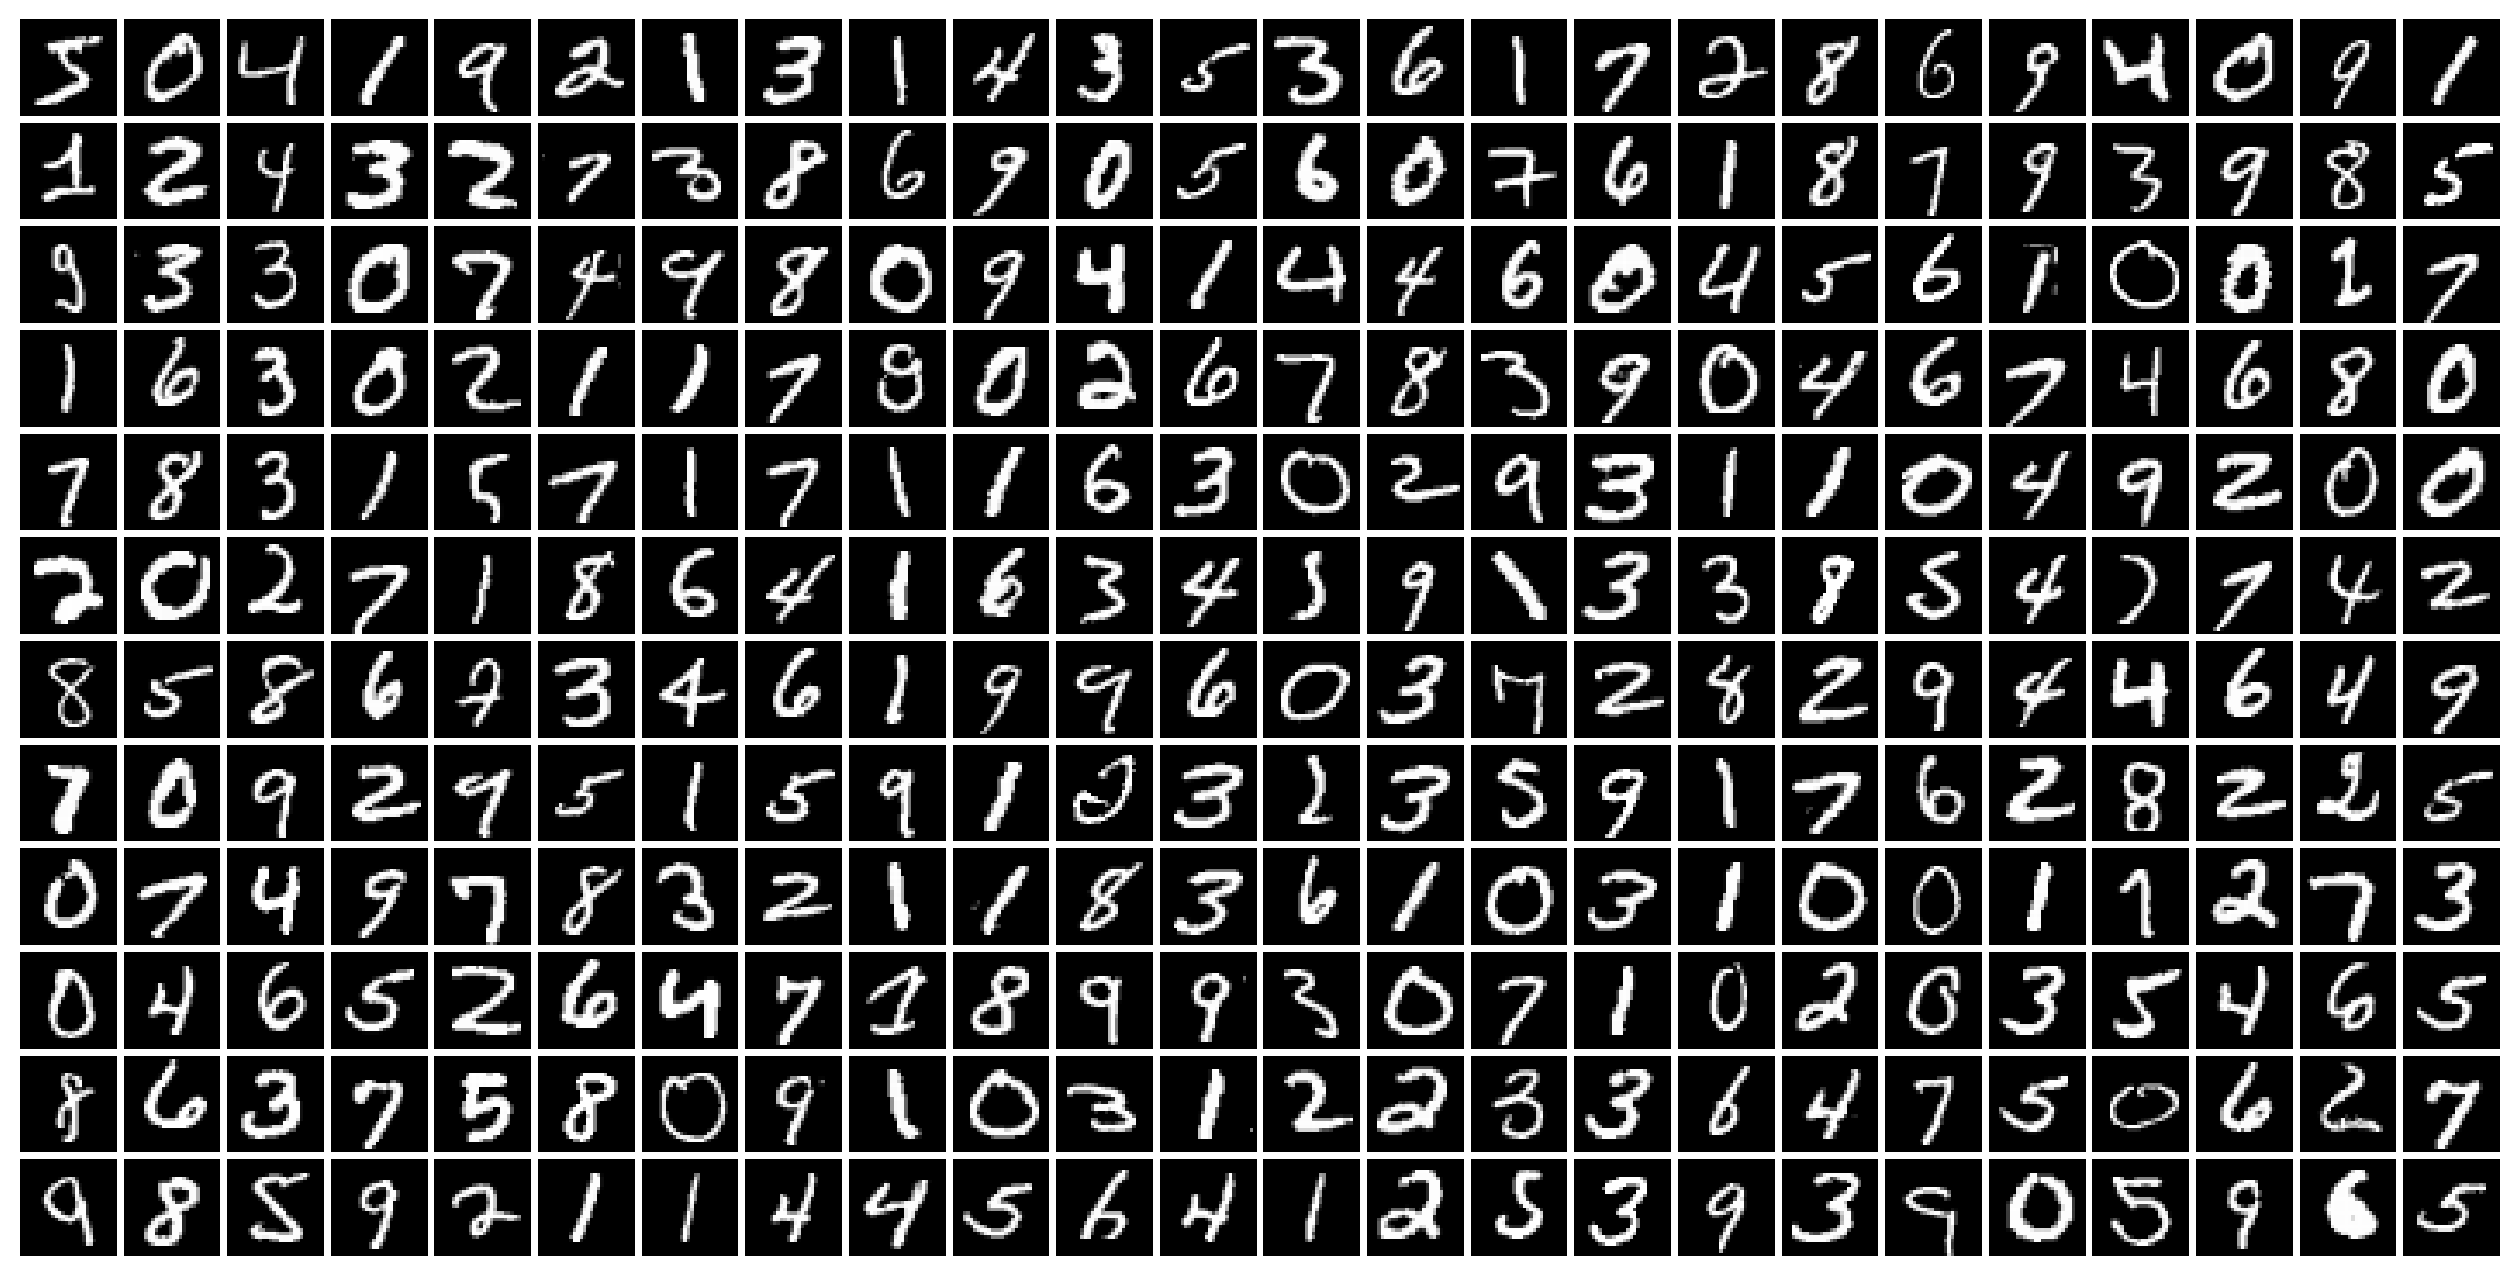

In [4]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# Part 1: $L^1$ and $L^2$ penalties

In [5]:
class RBM:
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        l1_penalty: float,
        l2_penalty: float,
    ):
        self.vsize = vsize
        self.hsize = hsize

        # Training hyper-params
        self.lr = lr
        self.momentum = momentum
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

        # Initialize
        self.reset()

    def reset(self):
        # Xavier initialization
        scale = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)

        # Zero initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Velocity (momentum) tensor initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.vsize)
        self.m_c = zeros(self.hsize)

    def probas_v(self, h: NDArray) -> NDArray:
        return sigmoid(self.b + h @ self.w.T)

    def probas_h(self, v: NDArray) -> NDArray:
        return sigmoid(self.c + v @ self.w)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        batch_size = v.shape[0]
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v) > rand(batch_size, self.hsize)
            σ = self.probas_v(h)
            if k < steps - 1:
                v = σ > rand(batch_size, self.vsize)

        return σ

In [6]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    σ = rbm.sample(v, steps=1)
    return 1 / batch_size * np.sum((v - σ) ** 2)

### CDK with regulatization

Implement the Contrastive Divergence algorithm with $L^1$ and $L^2$ penalties. If
```python
rbm.l1_penalty > 0
```
the algorithm should constrain the weights with $L^1$ penalty. Otherwise, if
```python
rbm.l2_penalty > 0
```
the algorithm should constrain the weights with $L^2$ penalty.

Do **not** apply the penalties to the biases!

In [7]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = σ > rand(batch_size, rbm.hsize)
    v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)
    for _ in range(k - 1):
        h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
        v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v)

    grad_w += 1 / batch_size * (v.T @ σ)
    grad_b += 1 / batch_size * (v.sum(axis=0))
    grad_c += 1 / batch_size * (σ.sum(axis=0))

    # --- Penalties
    grad_w += rbm.l1_penalty * np.sign(rbm.w) + rbm.l2_penalty * rbm.w

    # Update params
    # -------------
    rbm.m_w = rbm.momentum * rbm.m_w - rbm.lr * grad_w
    rbm.m_b = rbm.momentum * rbm.m_b - rbm.lr * grad_b
    rbm.m_c = rbm.momentum * rbm.m_c - rbm.lr * grad_c

    rbm.w += rbm.m_w
    rbm.b += rbm.m_b
    rbm.c += rbm.m_c

## Comparison of regularization penalties

In [8]:
def train_epoch(rbm: RBM, dataset: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")


def run_training(
    rbm: RBM,
    dataset: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time

        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")


def draw_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    # filters = np.clip(filters, -1, 1)
    tiles(filters)

In [9]:
DATASET_SIZE = 20000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = mnist_train[:DATASET_SIZE]
dataset = dataset.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

In [10]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

### RBM with no regularization

In [11]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_plain = RBM(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_plain, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 0.64s, reconstruction error: 24.28
Epoch 2:	########################################	elapsed: 0.62s, reconstruction error: 20.31
Epoch 3:	########################################	elapsed: 0.60s, reconstruction error: 18.08
Epoch 4:	########################################	elapsed: 2.57s, reconstruction error: 16.82
Epoch 5:	########################################	elapsed: 0.67s, reconstruction error: 16.01
Epoch 6:	########################################	elapsed: 0.69s, reconstruction error: 15.09
Epoch 7:	########################################	elapsed: 0.57s, reconstruction error: 13.87
Epoch 8:	########################################	elapsed: 0.60s, reconstruction error: 13.16
Epoch 9:	########################################	elapsed: 0.65s, reconstruction error: 12.80
Epoch 10:	########################################	elapsed: 0.55s, reconstruction error: 12.37
Epoch 11:	########################################	elapsed:

### RBM with $L^1$ penalty

In [12]:
L1_PENALTY = 0.0001
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_l1 = RBM(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_l1, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 0.38s, reconstruction error: 24.34
Epoch 2:	########################################	elapsed: 0.33s, reconstruction error: 20.39
Epoch 3:	########################################	elapsed: 0.30s, reconstruction error: 18.10
Epoch 4:	########################################	elapsed: 0.40s, reconstruction error: 16.89
Epoch 5:	########################################	elapsed: 0.48s, reconstruction error: 16.04
Epoch 6:	########################################	elapsed: 0.48s, reconstruction error: 15.07
Epoch 7:	########################################	elapsed: 0.52s, reconstruction error: 13.83
Epoch 8:	########################################	elapsed: 0.43s, reconstruction error: 13.04
Epoch 9:	########################################	elapsed: 0.58s, reconstruction error: 12.71
Epoch 10:	########################################	elapsed: 0.60s, reconstruction error: 12.24
Epoch 11:	########################################	elapsed:

### RBM with $L^2$ penalty

In [13]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0005

np.random.seed(1234)
rbm_l2 = RBM(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_l2, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 0.46s, reconstruction error: 24.37
Epoch 2:	########################################	elapsed: 0.61s, reconstruction error: 20.35
Epoch 3:	########################################	elapsed: 0.49s, reconstruction error: 18.11
Epoch 4:	########################################	elapsed: 0.33s, reconstruction error: 16.93
Epoch 5:	########################################	elapsed: 0.46s, reconstruction error: 16.07
Epoch 6:	########################################	elapsed: 0.32s, reconstruction error: 15.19
Epoch 7:	########################################	elapsed: 0.39s, reconstruction error: 14.16
Epoch 8:	########################################	elapsed: 0.76s, reconstruction error: 13.27
Epoch 9:	########################################	elapsed: 0.56s, reconstruction error: 12.82
Epoch 10:	########################################	elapsed: 0.59s, reconstruction error: 12.37
Epoch 11:	########################################	elapsed:

### Plain filters

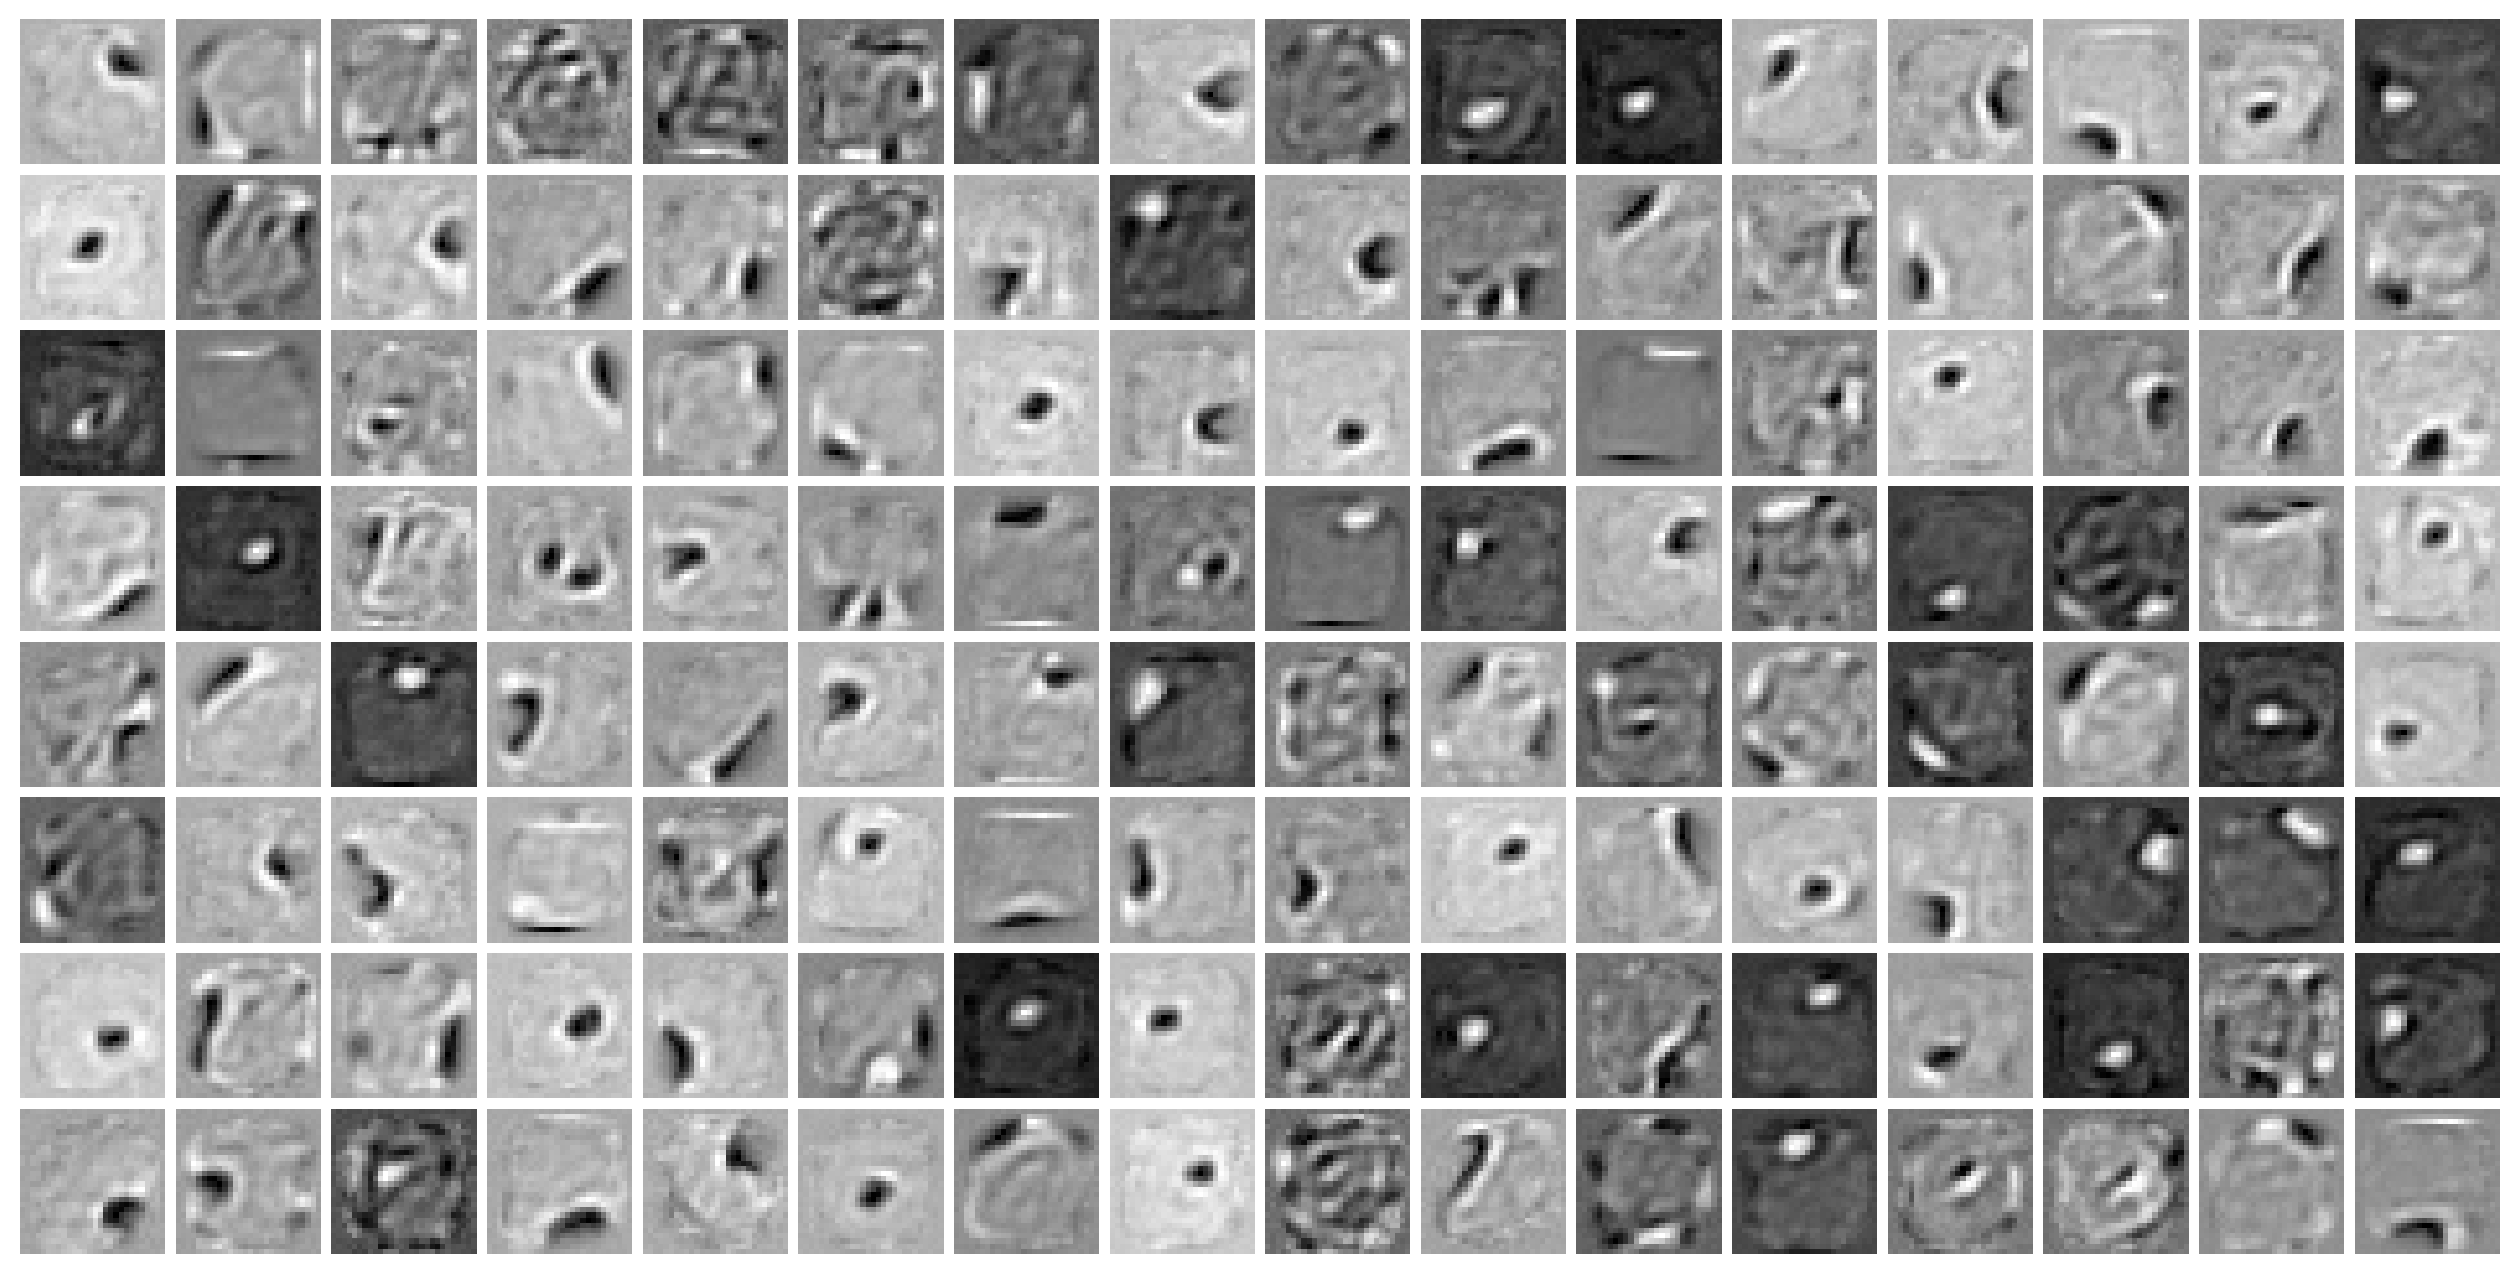

In [14]:
draw_filters(rbm_plain)

### $L^1$ filters

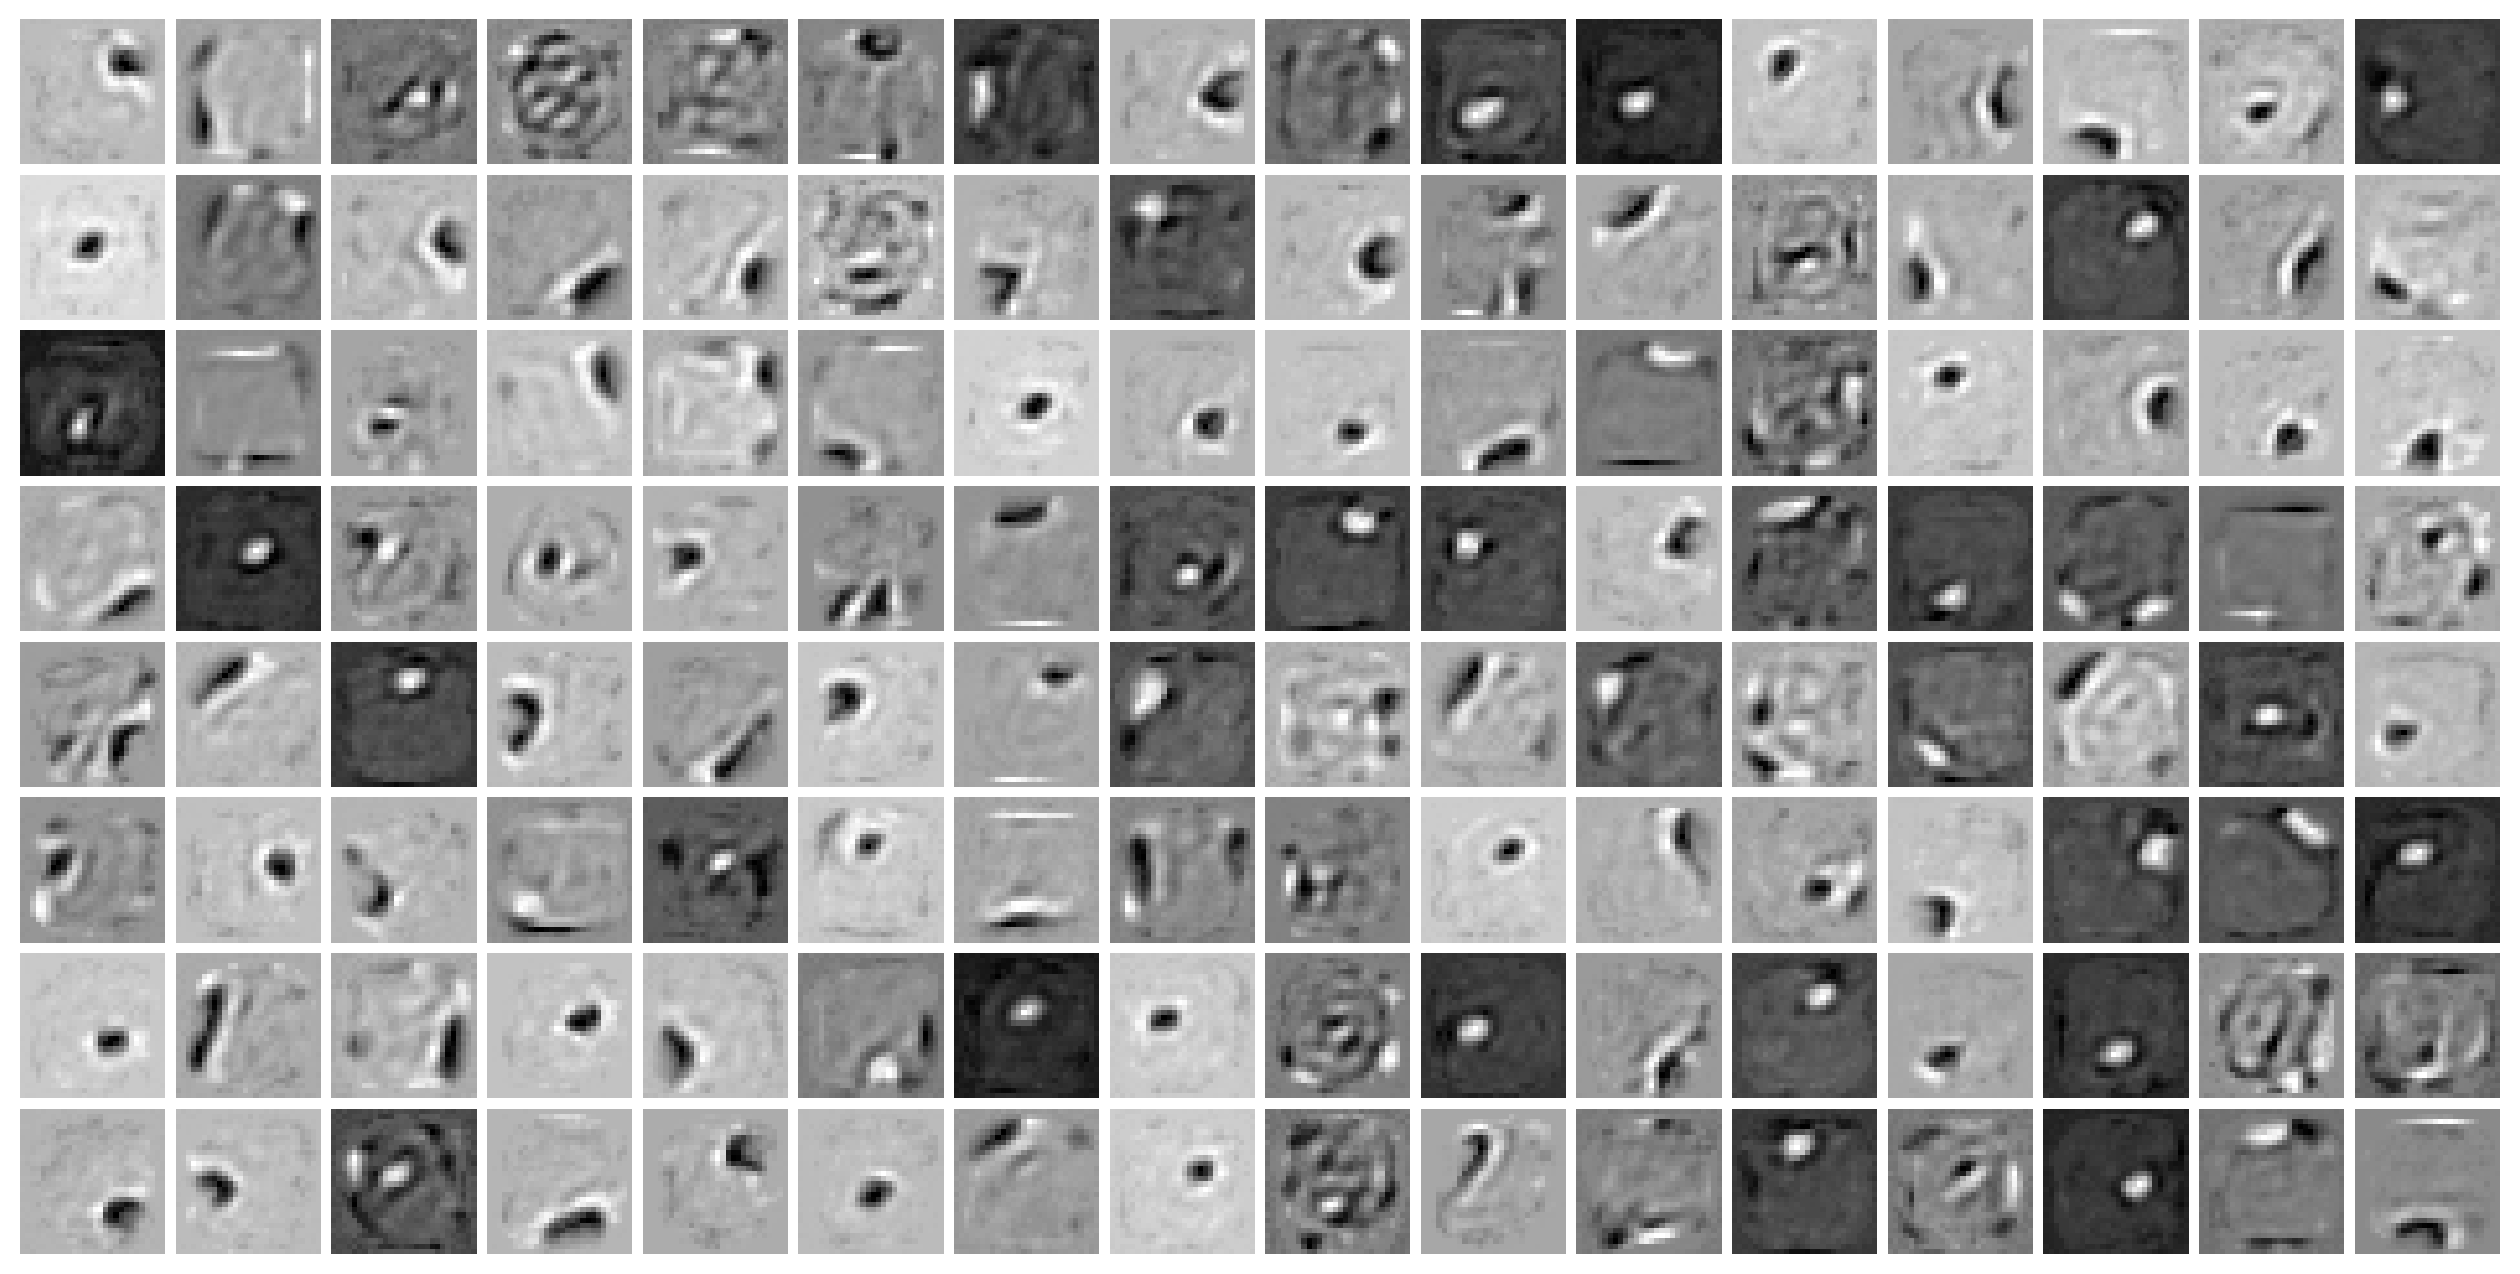

In [15]:
draw_filters(rbm_l1)

### $L^2$ filters

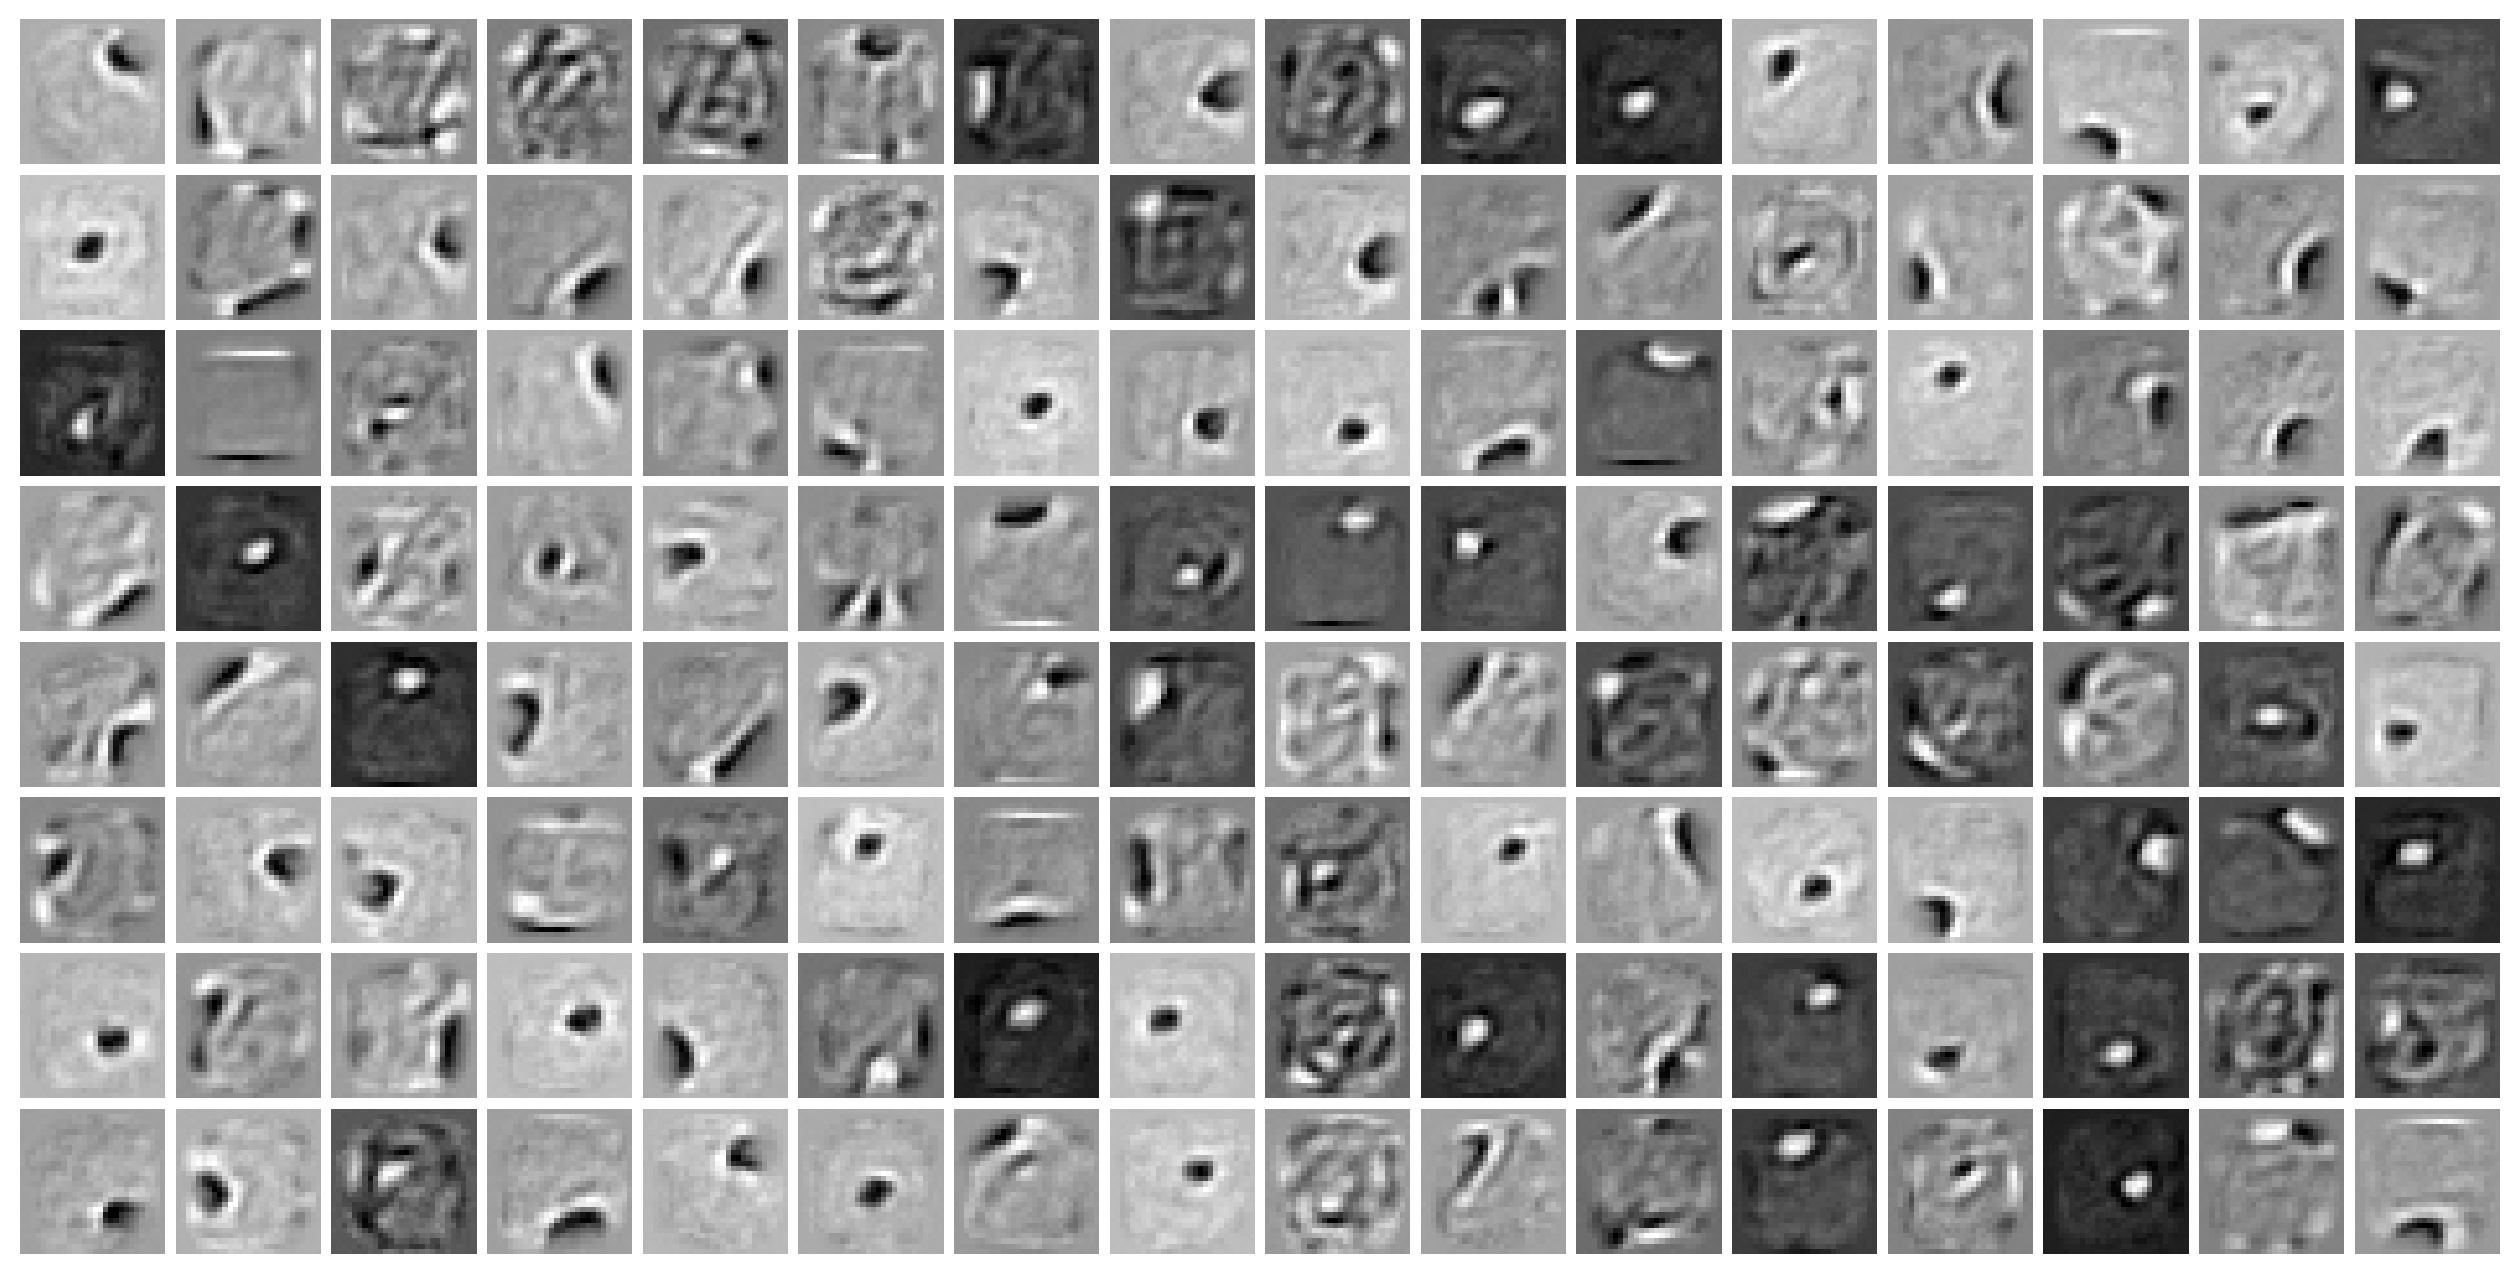

In [16]:
draw_filters(rbm_l2)

# Part 2: MLP pretraining

In [17]:
def softmax(x: NDArray) -> NDArray:
    m = x.max(axis=1, keepdims=True)
    y = np.exp(x - m)
    return y / y.sum(axis=1, keepdims=True)

In [18]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [34]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x


class Linear(Layer):
    def __init__(self, vsize: int, hsize: int, lr: float, momentum: float, l2_penalty: float):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.l2_penalty: float = l2_penalty
        self.reset()

    def reset(self):
        # Weights initialization
        scale = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
        # self.w = np.random.normal(0, 0.01, size=(self.vsize, self.hsize)).astype(np.float32)
        # Biases initialization
        self.b = zeros(self.hsize)
        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)
        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Penalties
        grad_w += self.l2_penalty * self.w

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # --- Propagate ∂Loss/∂x backward
        return grad_x

### Forward pass

In [35]:
def forward_pass(mlp: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in mlp:
        x = layer.forward(x, training=training)
    return x

### Error backpropagation

Extend the implementation of error backpropagation (from Lab 6) with $L^2$ penalty. Apply the penalty when:
```python
rbm.l2_penalty > 0
```

Do **not** apply the penalty to the biases.

In [36]:
def error_backpropagate(mlp: Sequence[Layer], X_batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(mlp))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `X_batch` if i=0)
        x = mlp[i - 1].y if i > 0 else X_batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = mlp[i].backward(x, grad_y)

### MLP training

In [48]:
def train_mlp(mlp: Sequence[Layer], dataset: NDArray, labels: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size

    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)

    for batch_idx, (X_batch, t_batch) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        # NOTE: in this implementation mlp returns *mlogits* and not probabilities
        y = forward_pass(mlp, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the cross entropy function.
        # NOTE: in this implementation mlp returns *mlogits* and thus we need to pass `y` through
        # the softmax function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (softmax(y) - t_batch)

        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, X_batch, grad_y)

        if batch_idx % round(batches_limit / 50) == 0:
            print("#", end="")

In [49]:
def classify(mlp: Sequence[Layer], X_batch: NDArray) -> NDArray:
    mlogits = forward_pass(mlp, X_batch, training=False)
    return np.argmax(mlogits, axis=1)


def run_mlp_training(
    mlp: Sequence[Layer],
    X_train: NDArray,
    t_train: NDArray,
    X_valid: NDArray,
    t_valid: NDArray,
    batch_size: int,
    epochs_count: int,
):

    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.9

        start_time = time.time()
        train_mlp(mlp, X_train, t_train, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, X_valid)
        accuracy = np.sum(predictions == t_valid) / predictions.shape[0]
        print("\telapsed: {0:>2.2}s, accuracy: {1:>2.2%}".format(elapsed, accuracy))

    print("Training finished!")


def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

## DBN Pretraining

In [50]:
def propagate_up(dbn: Sequence[RBM], n_layers: int, v: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in range(n_layers):
        v = dbn[i].probas_h(v)
    return v


def propagate_dn(dbn: Sequence[RBM], n_layers: int, h: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in reversed(range(n_layers)):
        h = dbn[i].probas_v(h)
    return h

In [51]:
def dbn_reconstuction_error(dbn: Sequence[RBM], n_layers: int, minibatch: NDArray) -> float:
    assert 0 <= n_layers < len(dbn)
    visible = propagate_up(dbn, n_layers, minibatch)
    return reconstuction_error(dbn[n_layers], visible)

In [52]:
def train_dbn_layer(dbn: Sequence[RBM], layer_idx: int, dataset: NDArray, batch_size: int):
    dataset = propagate_up(dbn, layer_idx, dataset)
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [53]:
def train_dbn(dbn, dataset, monitoring_set, batch_size, epochs_count):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch + 1), end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

##  Initializing MLP with DBN weights

Implement initialization of MLP weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the MLP weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [54]:
def initialize_mlp(mlp: Sequence[Layer], dbn: Sequence[RBM]):
    linear_layers = [layer for layer in mlp if isinstance(layer, Linear)]
    for layer, rbm in zip(linear_layers, dbn):
        layer.w = rbm.w.copy()
        layer.b = rbm.c.copy()

# MNIST digits classification

In [55]:
DATASET_SIZE = 10_000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

### Plain vs pretrained MLP comparison

In [56]:
from IPython.core.display import HTML


def compare_pretraining_results(
    mlp: Sequence[Layer],
    dbn: Sequence[RBM],
    X_train: NDArray,
    t_train: NDArray,
    X_valid: NDArray,
    t_valid: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer in mlp:
        layer.reset()

    display(HTML("<h3>Plain MLP training</h3>"))
    run_mlp_training(mlp, X_train, t_train, X_valid, t_valid, batch_size, epochs_count)

    display(HTML("<h3>Input layer filters in the plain MLP</h3>"))
    draw_layer_filters(mlp[0])

    display(HTML("<h3>DBN training</h3>"))
    train_dbn(dbn, X_train, monitoring_set, batch_size, epochs_count)

    for layer in mlp:
        layer.reset()

    initialize_mlp(mlp, dbn)

    display(HTML("<h3>Finetuning pretrained MLP</h3>"))
    run_mlp_training(mlp, X_train, t_train, X_valid, t_valid, batch_size, epochs_count)

    display(HTML("<h3>First layer filters in the DBN</h3>"))
    draw_filters(dbn[0])

    display(HTML("<h3>Input layer filters in the pretrained & finetuned MLP</h3>"))
    draw_layer_filters(mlp[0])

In [57]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5
L2_PENALTY = 0.00002

### Shallow neural network

Epoch 1:	########################################	elapsed: 0.24s, accuracy: 28.95%
Epoch 2:	########################################	elapsed: 0.13s, accuracy: 55.12%
Epoch 3:	########################################	elapsed: 0.14s, accuracy: 71.20%
Epoch 4:	########################################	elapsed: 0.12s, accuracy: 77.89%
Epoch 5:	########################################	elapsed: 0.12s, accuracy: 82.43%
Epoch 6:	########################################	elapsed: 0.11s, accuracy: 87.44%
Epoch 7:	########################################	elapsed: 0.21s, accuracy: 89.96%
Epoch 8:	########################################	elapsed: 0.13s, accuracy: 90.63%
Epoch 9:	########################################	elapsed: 0.13s, accuracy: 91.24%
Epoch 10:	########################################	elapsed: 0.11s, accuracy: 91.45%
Epoch 11:	########################################	elapsed: 0.25s, accuracy: 91.52%
Epoch 12:	########################################	elapsed: 0.12s, accuracy: 91.78%
E

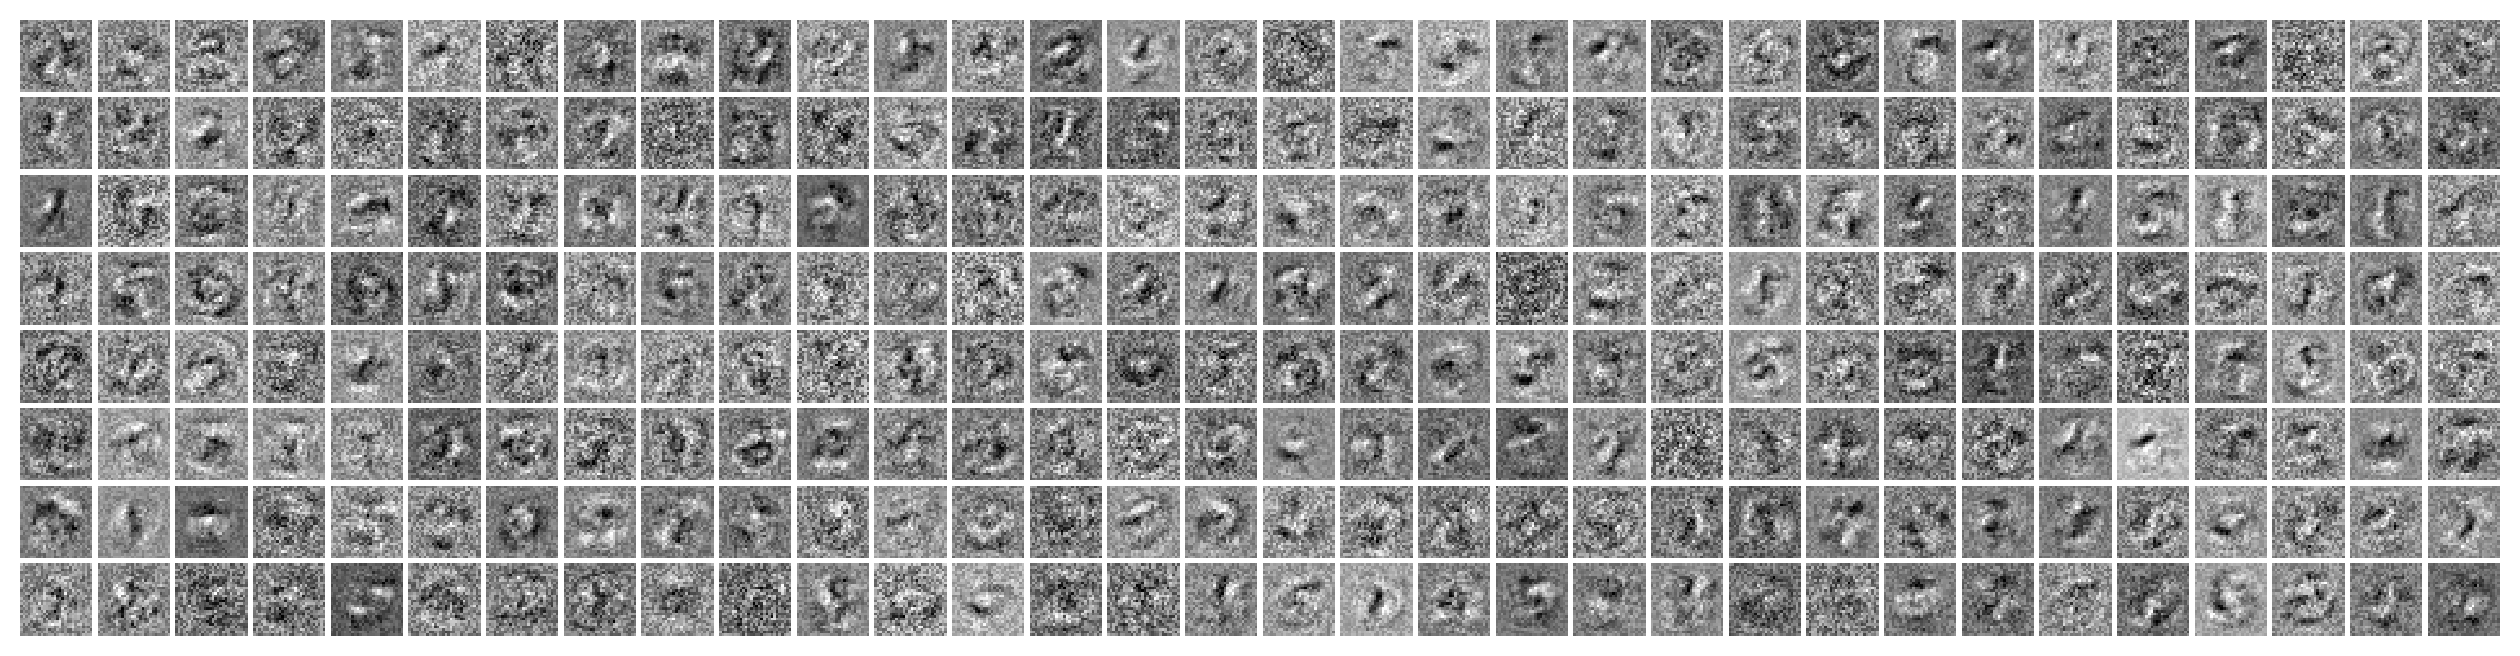


Learning layer 0
Epoch 1:	########################################	elapsed: 0.41s, reconstruction error: 26.65
Epoch 2:	########################################	elapsed: 0.46s, reconstruction error: 22.04
Epoch 3:	########################################	elapsed: 0.27s, reconstruction error: 19.14
Epoch 4:	########################################	elapsed: 0.27s, reconstruction error: 17.47
Epoch 5:	########################################	elapsed: 0.26s, reconstruction error: 16.28
Epoch 6:	########################################	elapsed: 0.26s, reconstruction error: 15.03
Epoch 7:	########################################	elapsed: 0.23s, reconstruction error: 13.40
Epoch 8:	########################################	elapsed: 0.23s, reconstruction error: 12.60
Epoch 9:	########################################	elapsed: 0.23s, reconstruction error: 12.06
Epoch 10:	########################################	elapsed: 0.26s, reconstruction error: 11.58
Epoch 11:	###############################

Epoch 1:	########################################	elapsed: 0.14s, accuracy: 93.76%
Epoch 2:	########################################	elapsed: 0.17s, accuracy: 94.86%
Epoch 3:	########################################	elapsed: 0.17s, accuracy: 95.39%
Epoch 4:	########################################	elapsed: 0.16s, accuracy: 95.74%
Epoch 5:	########################################	elapsed: 0.23s, accuracy: 95.93%
Epoch 6:	########################################	elapsed: 0.15s, accuracy: 96.14%
Epoch 7:	########################################	elapsed: 0.14s, accuracy: 96.29%
Epoch 8:	########################################	elapsed: 0.13s, accuracy: 96.41%
Epoch 9:	########################################	elapsed: 0.13s, accuracy: 96.43%
Epoch 10:	########################################	elapsed: 0.14s, accuracy: 96.47%
Epoch 11:	########################################	elapsed: 0.19s, accuracy: 96.53%
Epoch 12:	########################################	elapsed: 0.15s, accuracy: 96.58%
E

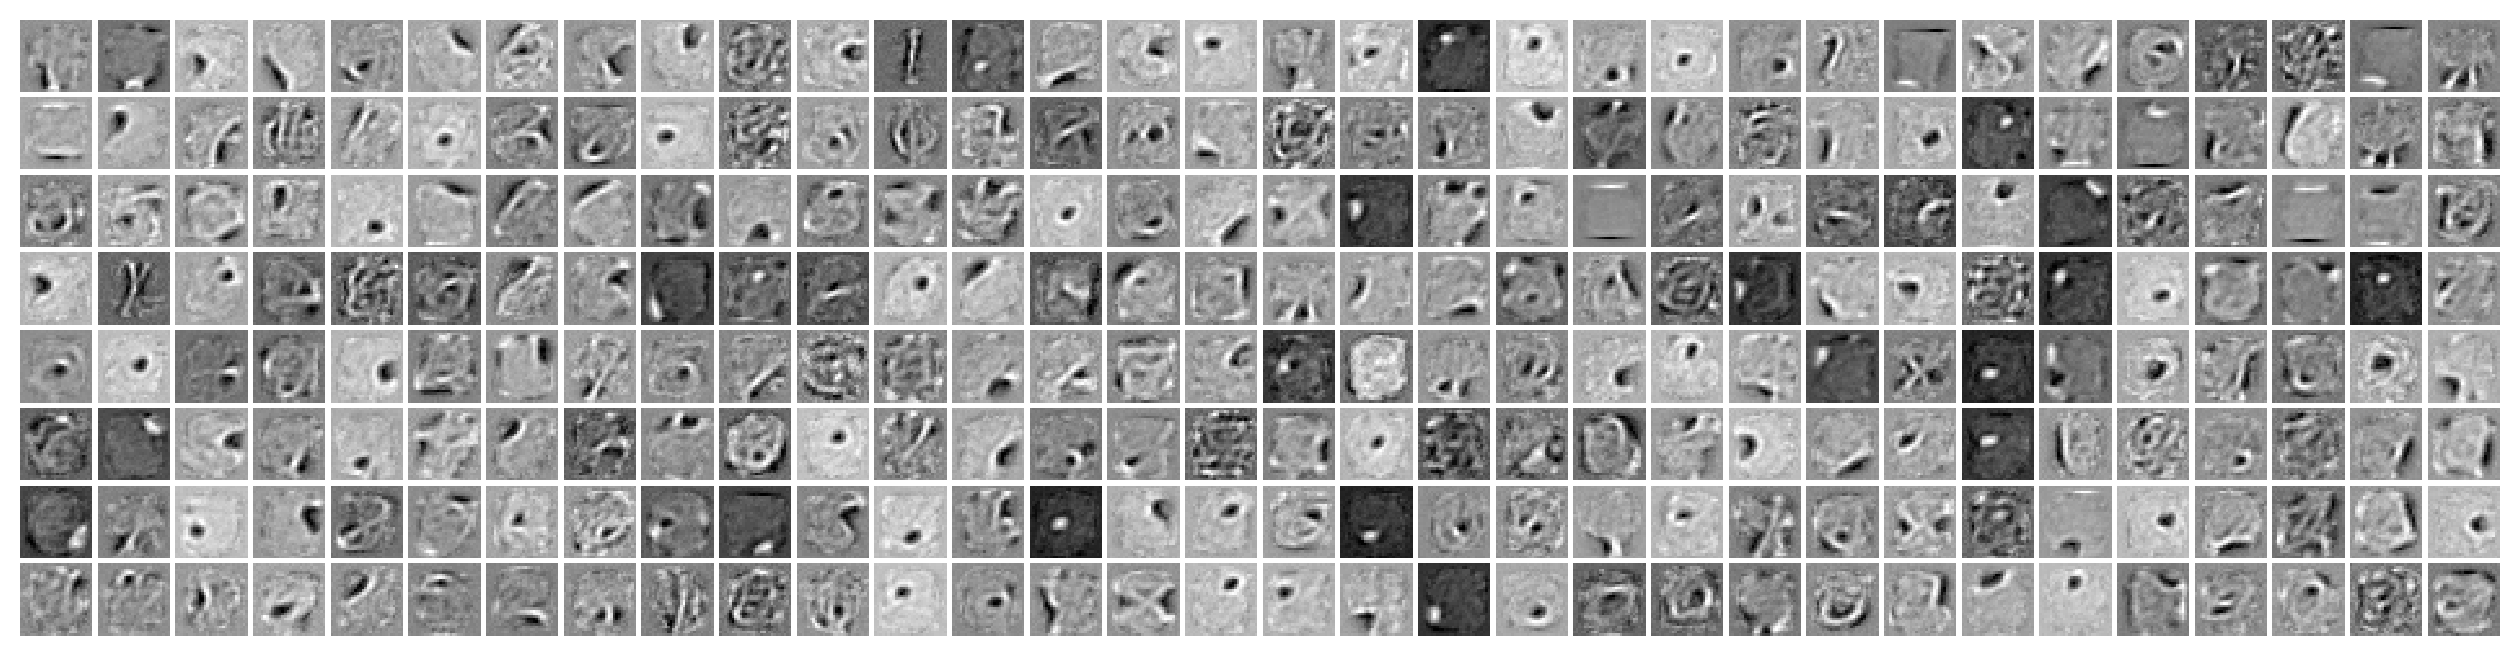

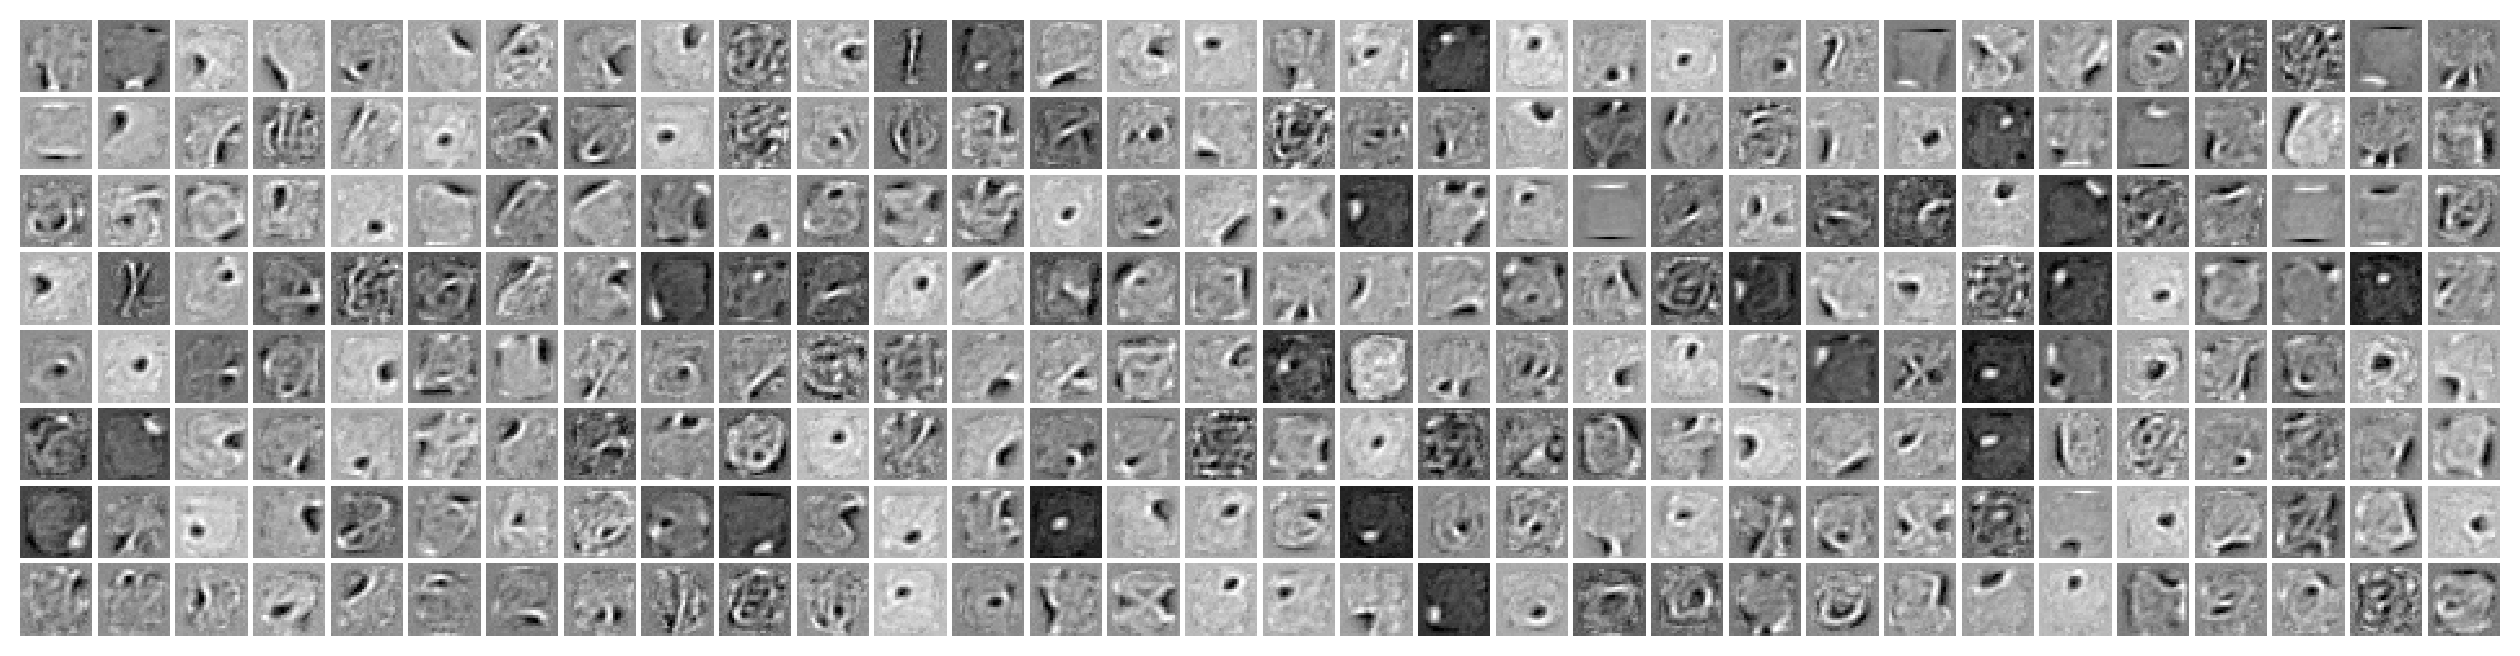

In [58]:
shallow_mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, L2_PENALTY),
]

shallow_dbn = [
    RBM(layer.vsize, layer.hsize, LEARNING_RATE, MOMENTUM, 0.0, L2_PENALTY)
    for layer in shallow_mlp[:-1]
    if isinstance(layer, Linear)
]

compare_pretraining_results(
    shallow_mlp,
    shallow_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

### Deep neural network

Epoch 1:	########################################	elapsed: 0.3s, accuracy: 11.35%
Epoch 2:	########################################	elapsed: 0.17s, accuracy: 11.35%
Epoch 3:	########################################	elapsed: 0.21s, accuracy: 11.35%
Epoch 4:	########################################	elapsed: 0.16s, accuracy: 29.01%
Epoch 5:	########################################	elapsed: 0.22s, accuracy: 44.90%
Epoch 6:	########################################	elapsed: 0.22s, accuracy: 72.87%
Epoch 7:	########################################	elapsed: 0.25s, accuracy: 82.88%
Epoch 8:	########################################	elapsed: 0.17s, accuracy: 87.69%
Epoch 9:	########################################	elapsed: 0.24s, accuracy: 88.28%
Epoch 10:	########################################	elapsed: 0.18s, accuracy: 88.99%
Epoch 11:	########################################	elapsed: 0.25s, accuracy: 90.06%
Epoch 12:	########################################	elapsed: 0.19s, accuracy: 90.72%
Ep

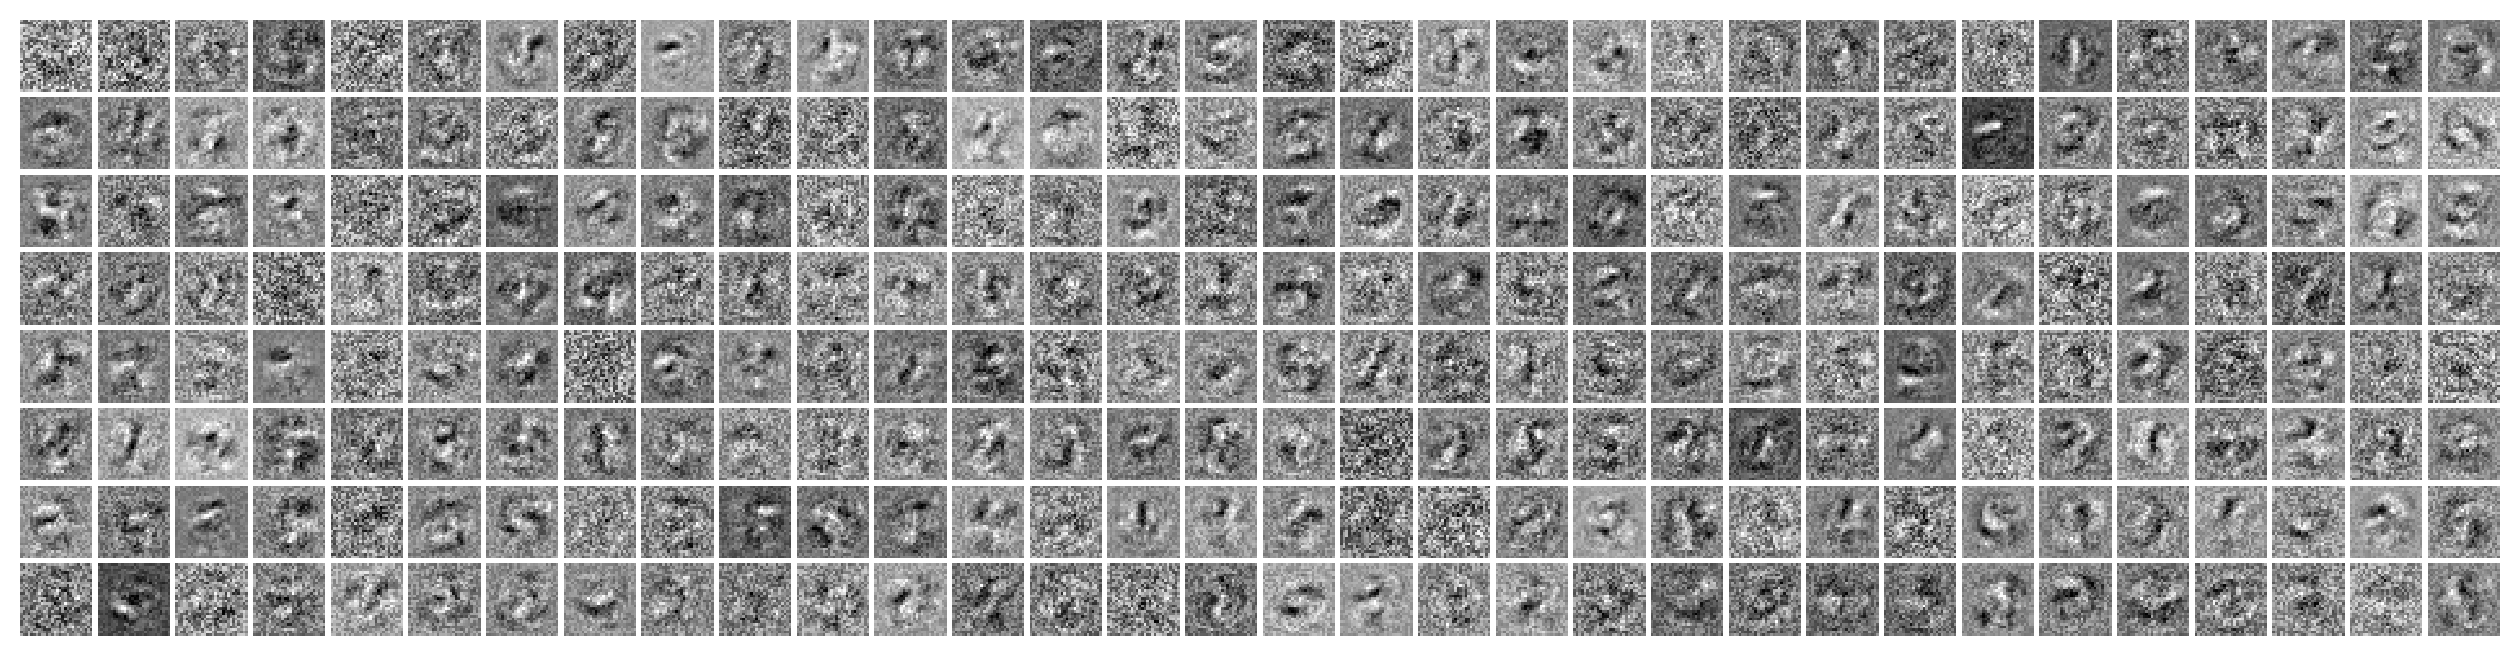


Learning layer 0
Epoch 1:	########################################	elapsed: 0.43s, reconstruction error: 26.78
Epoch 2:	########################################	elapsed: 0.27s, reconstruction error: 21.70
Epoch 3:	########################################	elapsed: 0.24s, reconstruction error: 18.90
Epoch 4:	########################################	elapsed: 0.24s, reconstruction error: 17.67
Epoch 5:	########################################	elapsed: 0.26s, reconstruction error: 16.28
Epoch 6:	########################################	elapsed: 0.27s, reconstruction error: 14.83
Epoch 7:	########################################	elapsed: 0.24s, reconstruction error: 13.16
Epoch 8:	########################################	elapsed: 0.24s, reconstruction error: 12.59
Epoch 9:	########################################	elapsed: 0.25s, reconstruction error: 11.94
Epoch 10:	########################################	elapsed: 0.24s, reconstruction error: 11.39
Epoch 11:	###############################

Epoch 1:	########################################	elapsed: 0.19s, accuracy: 94.11%
Epoch 2:	########################################	elapsed: 0.24s, accuracy: 95.05%
Epoch 3:	########################################	elapsed: 0.15s, accuracy: 95.56%
Epoch 4:	########################################	elapsed: 0.15s, accuracy: 95.92%
Epoch 5:	########################################	elapsed: 0.19s, accuracy: 96.18%
Epoch 6:	########################################	elapsed: 0.15s, accuracy: 96.37%
Epoch 7:	########################################	elapsed: 0.2s, accuracy: 96.47%
Epoch 8:	########################################	elapsed: 0.17s, accuracy: 96.56%
Epoch 9:	########################################	elapsed: 0.16s, accuracy: 96.60%
Epoch 10:	########################################	elapsed: 0.17s, accuracy: 96.63%
Epoch 11:	########################################	elapsed: 0.17s, accuracy: 96.67%
Epoch 12:	########################################	elapsed: 0.35s, accuracy: 96.73%
Ep

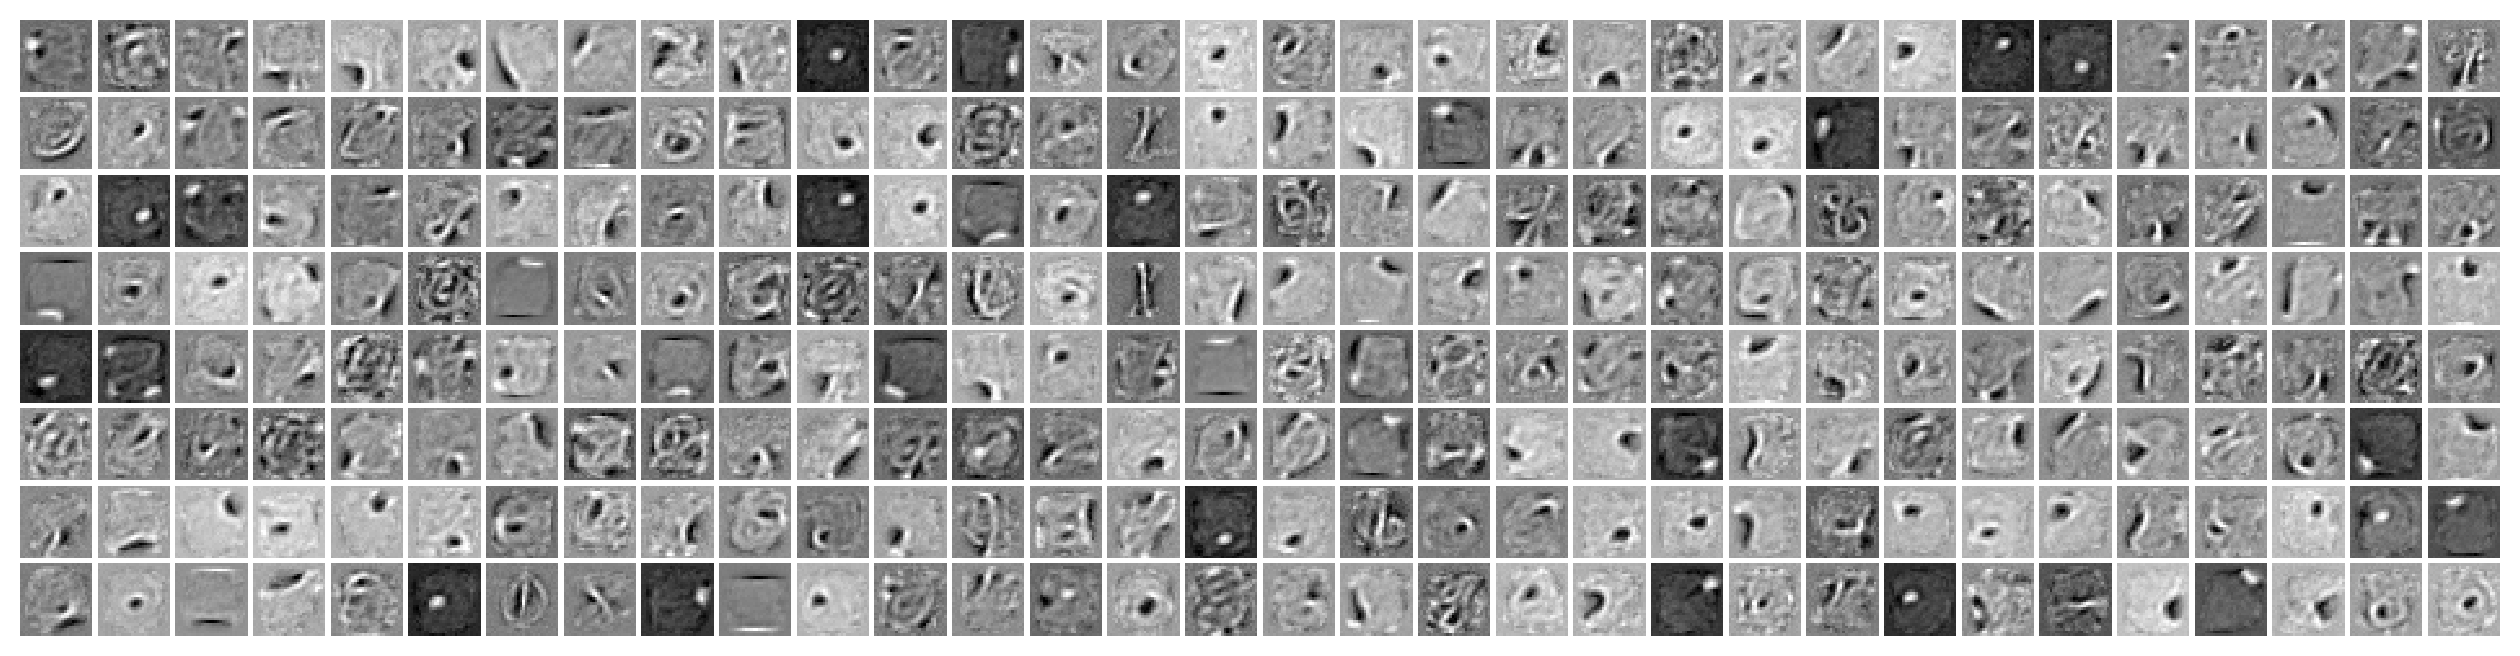

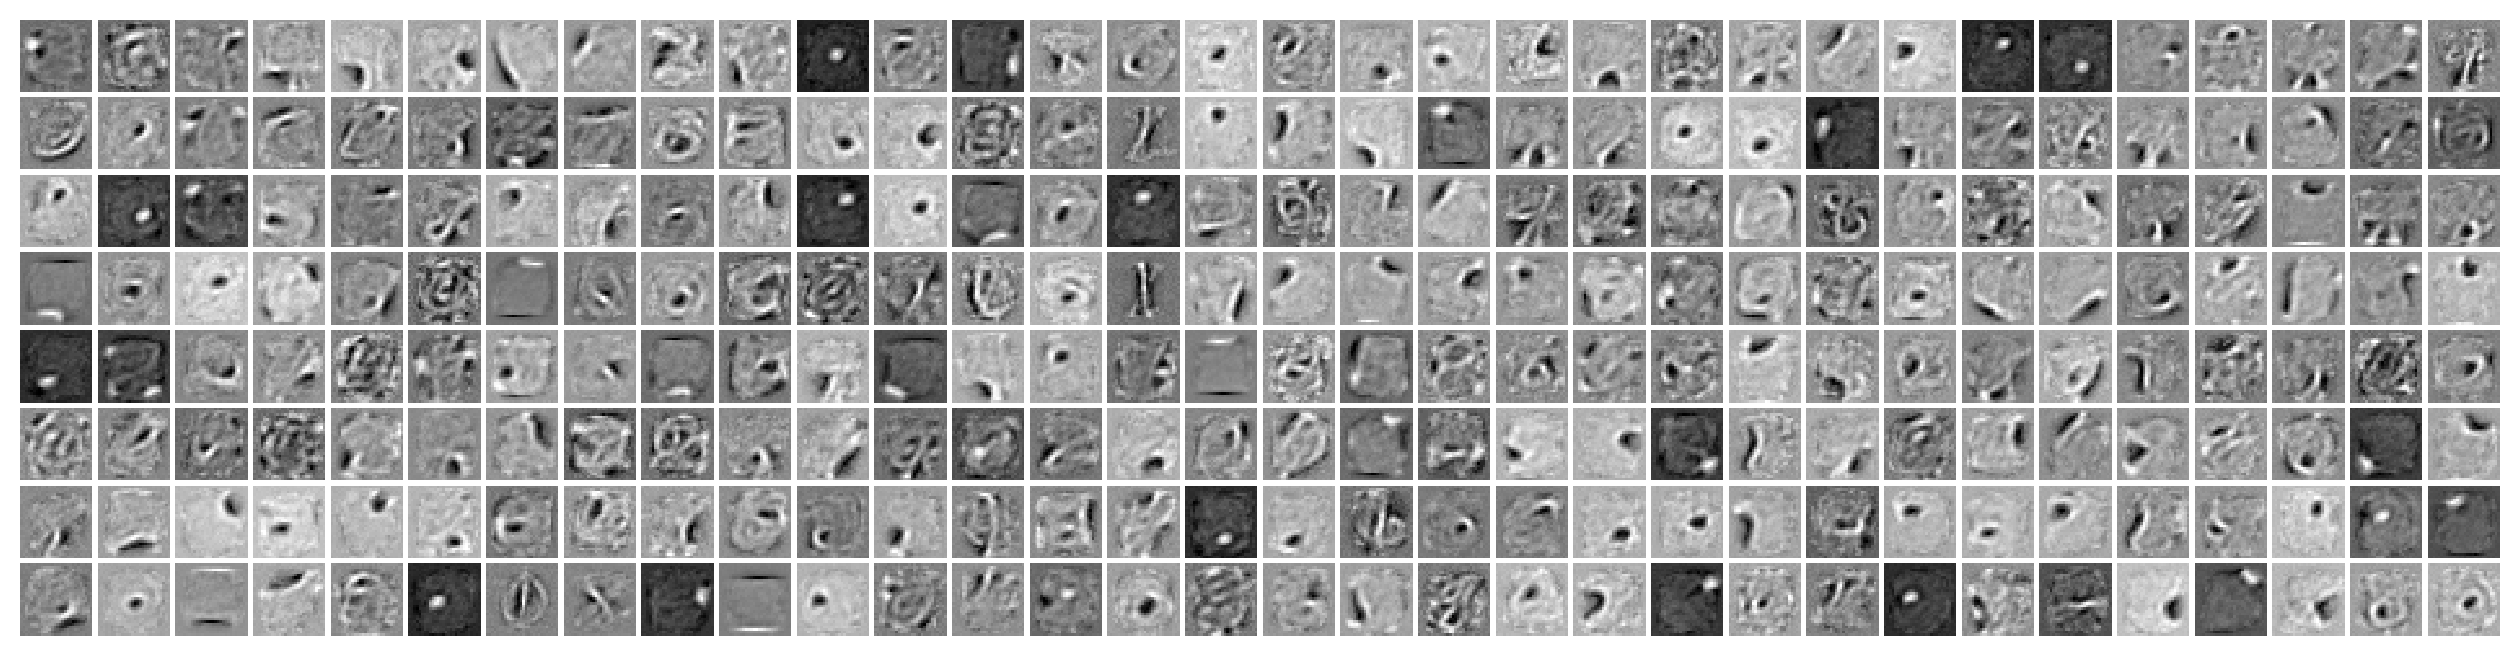

In [59]:
deep_mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, L2_PENALTY),
]

deep_dbn = [
    RBM(layer.vsize, layer.hsize, LEARNING_RATE, MOMENTUM, 0.0, L2_PENALTY)
    for layer in deep_mlp[:-1]
    if isinstance(layer, Linear)
]

compare_pretraining_results(
    deep_mlp,
    deep_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)